In [1]:
# import dependencies
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [90]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [91]:
# define X vars
x_vars = [
    ('pressure', 'DC_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'DC_GP101_default'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

In [92]:
# remove NANs
data = data.dropna(
    how='any', 
    subset=x_vars
)

# filter columns to keep only x_vars
data = data[x_vars].copy()
data.columns

MultiIndex([(    'pressure',                 'DC_GP101'),
            ('temperatures',           'DC_GT401_GM401'),
            ('temperatures',         'TA01_GT401_GM401'),
            ('temperatures',         'TA02_GT401_GM401'),
            ('temperatures',           'DC_GT101_GM101'),
            ('temperatures',           'DC_GT102_GM102'),
            ('temperatures',           'DC_GT103_GM103'),
            ('temperatures',           'DC_GT104_GM104'),
            ('temperatures',         'TA01_GT10X_GM10X'),
            ('temperatures',          'DC_GT301_damped'),
            ('temperatures',         'DC_GT301_outdoor'),
            (   'setpoints',         'DC_GP101_default'),
            (   'setpoints', 'TA01_GT10X_GM10X_default')],
           names=['category', 'sensor_ID'])

No. of unique vals for setpoints:
sensor_ID
DC_GP101_default            2
TA01_GT10X_GM10X_default    6
dtype: int64


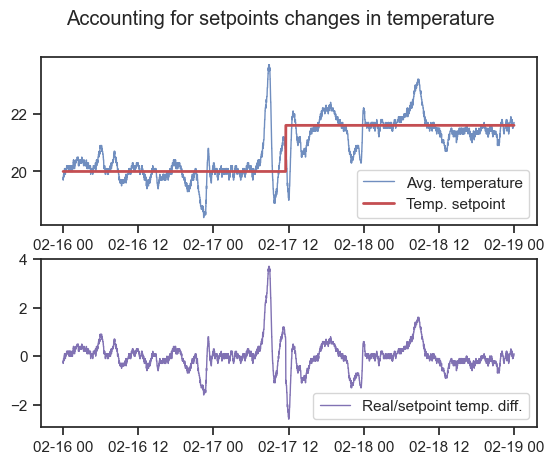

In [93]:
# indoor temp and indoor pressure is dependent on setpoints, 
# hence consider DIFF between setpoint and actual val for
# anomaly detection
print('No. of unique vals for setpoints:')
print(data.setpoints.nunique())

# create new cols w. diff
#data[('pressure', 'DC_GP101_diff')] = 0
data[('pressure', 'DC_GP101_diff')] = data[('pressure', 'DC_GP101')] - data[('setpoints', 'DC_GP101_default')]
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# plot differences f. last day
day = (2, (16, 17, 18))#, 18, 19, 20, 21))
subset = data.loc[day, :].droplevel(level=[0, 1, 2], axis=0).copy()

# set style
sns.set(style='ticks')

# get subplots (upper w. variable setpoint, lower w. accounted for)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints changes in temperature')

# plot avg. temp and setpoints
ax1.plot(
    subset.temperatures.TA01_GT10X_GM10X, 
    linewidth=1.0, 
    alpha=0.8, 
    label='Avg. temperature'
)
ax1.plot(
    subset.setpoints.TA01_GT10X_GM10X_default, 
    linewidth=2.0,
    alpha=1.0, 
    c='r', 
    label='Temp. setpoint'
)
ax2.plot(
    subset.temperatures.TA01_GT10X_GM10X_diff, 
    linewidth=1.0, 
    alpha=1.0, 
    c='m', 
    label='Real/setpoint temp. diff.'
)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.savefig(plot_path + 'setpoint.png')
plt.show()


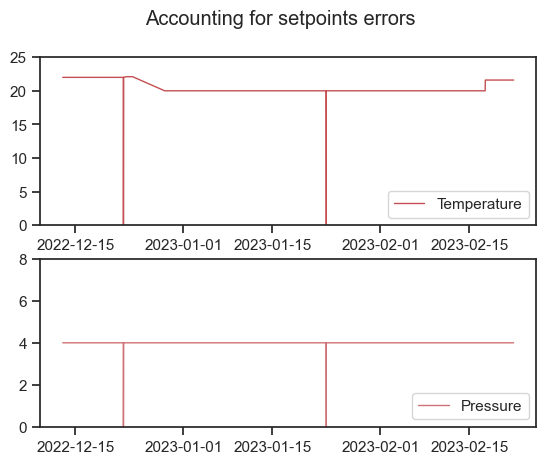

In [7]:
# also instances where setpoints have momentarily gone to zero. 
# display below.
# clearly erroneous?

# show setpoint errors)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints errors')

# plot setpoonts errors
ax1.plot(
    data.setpoints.TA01_GT10X_GM10X_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=1.0, 
    alpha=1.0, 
    c='r', 
    label='Temperature'
)
ax2.plot(
    data.setpoints.DC_GP101_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=1.0, 
    alpha=0.8, 
    c='r', 
    label='Pressure'
)

# set ylims f. visibility
ax1.set_ylim(0, 25)
ax2.set_ylim(0, 8)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.show()

In [94]:
### remove erroneous setpoint rows
data = data[
    (data.setpoints.TA01_GT10X_GM10X_default != 0.0) &
    (data.setpoints.DC_GP101_default != 0.0)
]

print('Minimum vals for setpoints:')
data.setpoints.min()

Minimum vals for setpoints:


sensor_ID
DC_GP101_default             4.0
TA01_GT10X_GM10X_default    20.0
dtype: float64

## Test AE on temperature data

In [9]:
# Normalize temperature data
x_train = data.temperatures.TA01_GT10X_GM10X_diff.values
x_train = (x_train - np.mean(x_train)) / np.std(x_train)

# create sequences
def seq_extract(x, n_steps):
    n = len(x)
    
    sequences = np.stack([
        x[i:i+n_steps] for i in range(n - n_steps)
    ])
    
    return sequences[..., np.newaxis]

x_train = seq_extract(
    x=x_train,
    n_steps=120
)


### Define model

In [10]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            512       
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 60, 32)           7200      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 60, 32)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 120, 64)          14400     
 ranspose)                                              

### Train model

In [11]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
2256/2256 [==============================] - 56s 24ms/step - loss: 0.0258 - val_loss: 0.0230
Epoch 2/10
2256/2256 [==============================] - 56s 25ms/step - loss: 0.0103 - val_loss: 0.0440
Epoch 3/10
2256/2256 [==============================] - 54s 24ms/step - loss: 0.0090 - val_loss: 0.1246
Epoch 4/10
2256/2256 [==============================] - 55s 24ms/step - loss: 0.0067 - val_loss: 0.0450
Epoch 5/10
2256/2256 [==============================] - 57s 25ms/step - loss: 0.0060 - val_loss: 0.0614
Epoch 6/10
2256/2256 [==============================] - 54s 24ms/step - loss: 0.0049 - val_loss: 0.0383


In [15]:
x_pred = model.predict(x_train)

5639/5639 [==============================] - 42s 7ms/step


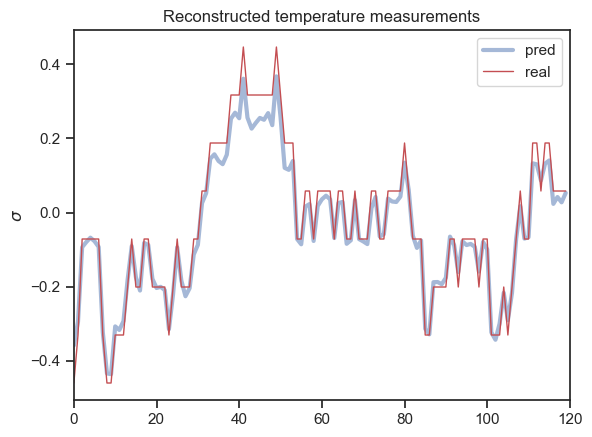

In [127]:
plt.plot(x_pred[0], label='pred', c='b', alpha=0.5, linewidth=3.0)
plt.plot(x_train[0], label='real', c='r', alpha=1.0, linewidth=1.0)

plt.title('Reconstructed temperature measurements')
plt.ylabel('$\sigma$')
plt.xlim(0, 120)
plt.legend()

plt.savefig(fname=plot_path + 'reconstructed.png', dpi=500)

In [118]:
# get MAE loss from training the AE
train_mae_loss = np.mean(np.abs(x_pred - x_train), axis=1)

# set a threshold, roughly the maximum difference in standard deviations from the mean
threshold = 1.0

# get index and create temp dataset w. flags f. anomalies
idx = np.squeeze(np.array(train_mae_loss) > threshold)
temp = data.iloc[120:].copy()
temp['flag'] = idx

# groupby individual days and plot number of flagged observations
errs = temp.groupby(by=['month', 'day'])['flag'].sum()

# print "anomaly" dates:
print('By setting the threshold to {} s.d., we get the following flagged dates:'.format(threshold))
errs[errs > 0]

By setting the threshold to 1.0 s.d., we get the following flagged dates:


month  day
1      5      466
       21     233
12     14     102
Name: flag, dtype: int64